In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import InceptionV3

In [2]:
currentPath = os.getcwd()
print(currentPath)

/home/ec2-user/SageMaker


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


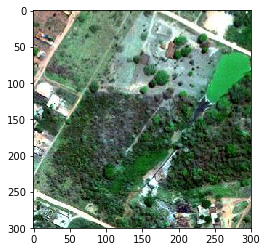

In [4]:
trainDB = currentPath + os.sep + "dataset" +  os.sep + "train20"
valDB = currentPath + os.sep + "dataset" +  os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
InceptionWeightsPretrained = currentPath + os.sep + "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
model_name = "InceptionV3"
classList = os.listdir(trainDB)
classList.sort()

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_7_8_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
lr = 0.00012
batch_size = 20
num_epochs = 700
pre_train_epochs = 20

num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 299, 299, 3
num_categories = len(classList)

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval = 0.)
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 927 images belonging to 62 classes.
Found 305 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
input = Input(shape=(img_rows, img_cols, img_channel))

In [9]:
def InceptionV3Custom(shape,pretrainedweights, input_tensor, classes):
    InV3NoTop = InceptionV3(
        include_top=False, weights=pretrainedweights, input_tensor=input_tensor, input_shape=shape)
    
    InV3Out = InV3NoTop.layers[-1].output
    x = GlobalAvgPool2D()(InV3Out)
    output = Dense(classes, activation="softmax")(x)
    model = Model(input_tensor, output)
        
    return model

In [10]:
model = InceptionV3Custom((img_rows, img_cols, img_channel),InceptionWeightsPretrained, input, num_categories)

model.summary()
#plot_model(model, show_shapes=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________

In [11]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=[tensorflow.keras.metrics.CategoricalAccuracy()])

In [12]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Epoch 1/700
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
4/4 [==============================] - 34s 9s/step - loss: 0.0868 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0852 - val_categorical_accuracy: 0.0250
Epoch 2/700
4/4 [==============================] - 4s 966ms/step - loss: 0.0864 - categorical_accuracy: 0.0000e+00 - val_loss: 0.0859 - val_categorical_accuracy: 0.0000e+00
Epoch 3/700
4/4 [==============================] - 4s 983ms/step - loss: 0.0844 - categorical_accuracy: 0.0500 - val_loss: 0.0855 - val_categorical_accuracy: 0.0125
Epoch 4/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0833 - categorical_accuracy: 0.0375 - val_loss: 0.0848 - val_categorical_accuracy: 0.0000e+00
Epoch 5/700
4/4 [==============================] - 4s 996ms/step - loss: 0.0816 - categorical_accuracy: 0.0250 - val_loss: 0.0846 - val_categorical_accuracy: 0.0250
Epoch 6/700
4/4 [==============================] - 4s 972ms/step - 

4/4 [==============================] - 4s 889ms/step - loss: 0.0719 - categorical_accuracy: 0.1194 - val_loss: 0.0778 - val_categorical_accuracy: 0.0750
Epoch 23/700
4/4 [==============================] - 4s 982ms/step - loss: 0.0708 - categorical_accuracy: 0.1000 - val_loss: 0.0776 - val_categorical_accuracy: 0.0750
Epoch 24/700
4/4 [==============================] - 4s 1s/step - loss: 0.0644 - categorical_accuracy: 0.3500 - val_loss: 0.0768 - val_categorical_accuracy: 0.0750
Epoch 25/700
4/4 [==============================] - 4s 1s/step - loss: 0.0619 - categorical_accuracy: 0.3125 - val_loss: 0.0754 - val_categorical_accuracy: 0.1125
Epoch 26/700
4/4 [==============================] - 4s 1s/step - loss: 0.0609 - categorical_accuracy: 0.3375 - val_loss: 0.0752 - val_categorical_accuracy: 0.1125
Epoch 27/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0588 - categorical_accuracy: 0.2875 - val_loss: 0.0753 - val_categorical_accuracy: 0.0875
Epoch 28/700
4/4 [========

4/4 [==============================] - 4s 997ms/step - loss: 0.0543 - categorical_accuracy: 0.4250 - val_loss: 0.0656 - val_categorical_accuracy: 0.1750
Epoch 45/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0543 - categorical_accuracy: 0.3500 - val_loss: 0.0654 - val_categorical_accuracy: 0.2125
Epoch 46/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0495 - categorical_accuracy: 0.4500 - val_loss: 0.0654 - val_categorical_accuracy: 0.2000
Epoch 47/700
4/4 [==============================] - 4s 1s/step - loss: 0.0562 - categorical_accuracy: 0.3125 - val_loss: 0.0658 - val_categorical_accuracy: 0.1750
Epoch 48/700
4/4 [==============================] - 4s 1s/step - loss: 0.0440 - categorical_accuracy: 0.5250 - val_loss: 0.0659 - val_categorical_accuracy: 0.1875
Epoch 49/700
4/4 [==============================] - 4s 1s/step - loss: 0.0437 - categorical_accuracy: 0.6000 - val_loss: 0.0662 - val_categorical_accuracy: 0.2375
Epoch 50/700
4/4 [========

Epoch 67/700
4/4 [==============================] - 5s 1s/step - loss: 0.0346 - categorical_accuracy: 0.6750 - val_loss: 0.0667 - val_categorical_accuracy: 0.2750
Epoch 68/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0383 - categorical_accuracy: 0.6375 - val_loss: 0.0666 - val_categorical_accuracy: 0.2750
Epoch 69/700
4/4 [==============================] - 4s 890ms/step - loss: 0.0421 - categorical_accuracy: 0.5224 - val_loss: 0.0664 - val_categorical_accuracy: 0.2750
Epoch 70/700
4/4 [==============================] - 4s 981ms/step - loss: 0.0387 - categorical_accuracy: 0.5625 - val_loss: 0.0661 - val_categorical_accuracy: 0.2750
Epoch 71/700
4/4 [==============================] - 4s 1s/step - loss: 0.0335 - categorical_accuracy: 0.6500 - val_loss: 0.0656 - val_categorical_accuracy: 0.2875
Epoch 72/700
4/4 [==============================] - 4s 1s/step - loss: 0.0295 - categorical_accuracy: 0.7500 - val_loss: 0.0651 - val_categorical_accuracy: 0.2875
Epoch 73/700


4/4 [==============================] - 4s 990ms/step - loss: 0.0331 - categorical_accuracy: 0.7000 - val_loss: 0.0632 - val_categorical_accuracy: 0.2875
Epoch 90/700
4/4 [==============================] - 4s 899ms/step - loss: 0.0253 - categorical_accuracy: 0.7910 - val_loss: 0.0632 - val_categorical_accuracy: 0.2875
Epoch 91/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0274 - categorical_accuracy: 0.7625 - val_loss: 0.0632 - val_categorical_accuracy: 0.2875
Epoch 92/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0304 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 93/700
4/4 [==============================] - 4s 984ms/step - loss: 0.0319 - categorical_accuracy: 0.7000 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 94/700
4/4 [==============================] - 4s 1s/step - loss: 0.0316 - categorical_accuracy: 0.6750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 95/700
4/4 [==

4/4 [==============================] - 4s 897ms/step - loss: 0.0352 - categorical_accuracy: 0.7612 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 112/700
4/4 [==============================] - 4s 994ms/step - loss: 0.0336 - categorical_accuracy: 0.6625 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 113/700
4/4 [==============================] - 4s 1s/step - loss: 0.0293 - categorical_accuracy: 0.7750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 114/700
4/4 [==============================] - 4s 1s/step - loss: 0.0302 - categorical_accuracy: 0.7000 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 115/700
4/4 [==============================] - 4s 991ms/step - loss: 0.0276 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 116/700
4/4 [==============================] - 4s 983ms/step - loss: 0.0314 - categorical_accuracy: 0.6875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 117/700
4/4 

4/4 [==============================] - 4s 1s/step - loss: 0.0269 - categorical_accuracy: 0.7750 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 134/700
4/4 [==============================] - 4s 994ms/step - loss: 0.0300 - categorical_accuracy: 0.7250 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 135/700
4/4 [==============================] - 4s 1s/step - loss: 0.0269 - categorical_accuracy: 0.7750 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 136/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0308 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 137/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0298 - categorical_accuracy: 0.7500 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 138/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0301 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 139/700
4/4 

4/4 [==============================] - 4s 1s/step - loss: 0.0299 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 156/700
4/4 [==============================] - 4s 903ms/step - loss: 0.0311 - categorical_accuracy: 0.7612 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 157/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0291 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 158/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0339 - categorical_accuracy: 0.6625 - val_loss: 0.0630 - val_categorical_accuracy: 0.2375
Epoch 159/700
4/4 [==============================] - 4s 1s/step - loss: 0.0289 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 160/700
4/4 [==============================] - 4s 991ms/step - loss: 0.0321 - categorical_accuracy: 0.6875 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 161/700
4/4 

4/4 [==============================] - 4s 1s/step - loss: 0.0331 - categorical_accuracy: 0.6875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 178/700
4/4 [==============================] - 4s 1s/step - loss: 0.0321 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 179/700
4/4 [==============================] - 4s 1s/step - loss: 0.0285 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 180/700
4/4 [==============================] - 4s 1s/step - loss: 0.0286 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 181/700
4/4 [==============================] - 4s 892ms/step - loss: 0.0334 - categorical_accuracy: 0.7164 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 182/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0282 - categorical_accuracy: 0.8000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 183/700
4/4 [=====

4/4 [==============================] - 4s 991ms/step - loss: 0.0282 - categorical_accuracy: 0.8375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 200/700
4/4 [==============================] - 4s 1s/step - loss: 0.0299 - categorical_accuracy: 0.7750 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 201/700
4/4 [==============================] - 4s 920ms/step - loss: 0.0308 - categorical_accuracy: 0.8209 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 202/700
4/4 [==============================] - 4s 1s/step - loss: 0.0288 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 203/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0319 - categorical_accuracy: 0.7250 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 204/700
4/4 [==============================] - 4s 989ms/step - loss: 0.0270 - categorical_accuracy: 0.8250 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 205/700
4/4 

4/4 [==============================] - 4s 990ms/step - loss: 0.0267 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 222/700
4/4 [==============================] - 4s 985ms/step - loss: 0.0294 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 223/700
4/4 [==============================] - 4s 989ms/step - loss: 0.0317 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 224/700
4/4 [==============================] - 4s 1s/step - loss: 0.0314 - categorical_accuracy: 0.6875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 225/700
4/4 [==============================] - 4s 1000ms/step - loss: 0.0298 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 226/700
4/4 [==============================] - 4s 1s/step - loss: 0.0283 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 227/700
4/4

4/4 [==============================] - 4s 987ms/step - loss: 0.0310 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 244/700
4/4 [==============================] - 4s 987ms/step - loss: 0.0316 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 245/700
4/4 [==============================] - 4s 988ms/step - loss: 0.0283 - categorical_accuracy: 0.7500 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 246/700
4/4 [==============================] - 4s 979ms/step - loss: 0.0290 - categorical_accuracy: 0.7875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 247/700
4/4 [==============================] - 4s 1s/step - loss: 0.0275 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 248/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0293 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 249/700
4

4/4 [==============================] - 4s 996ms/step - loss: 0.0287 - categorical_accuracy: 0.7875 - val_loss: 0.0633 - val_categorical_accuracy: 0.2375
Epoch 266/700
4/4 [==============================] - 4s 993ms/step - loss: 0.0305 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 267/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0267 - categorical_accuracy: 0.7875 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 268/700
4/4 [==============================] - 4s 982ms/step - loss: 0.0304 - categorical_accuracy: 0.7000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 269/700
4/4 [==============================] - 4s 982ms/step - loss: 0.0321 - categorical_accuracy: 0.6750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 270/700
4/4 [==============================] - 4s 993ms/step - loss: 0.0300 - categorical_accuracy: 0.6875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 271/70

4/4 [==============================] - 4s 989ms/step - loss: 0.0295 - categorical_accuracy: 0.7250 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 288/700
4/4 [==============================] - 4s 991ms/step - loss: 0.0271 - categorical_accuracy: 0.7500 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 289/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0304 - categorical_accuracy: 0.6875 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 290/700
4/4 [==============================] - 4s 892ms/step - loss: 0.0341 - categorical_accuracy: 0.6716 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 291/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0322 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 292/700
4/4 [==============================] - 4s 985ms/step - loss: 0.0295 - categorical_accuracy: 0.8375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 293/70

4/4 [==============================] - 4s 993ms/step - loss: 0.0303 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 310/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0311 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 311/700
4/4 [==============================] - 4s 991ms/step - loss: 0.0291 - categorical_accuracy: 0.7000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 312/700
4/4 [==============================] - 4s 987ms/step - loss: 0.0276 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 313/700
4/4 [==============================] - 4s 987ms/step - loss: 0.0311 - categorical_accuracy: 0.6750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 314/700
4/4 [==============================] - 4s 994ms/step - loss: 0.0289 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 315/70

4/4 [==============================] - 4s 1s/step - loss: 0.0253 - categorical_accuracy: 0.8500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 332/700
4/4 [==============================] - 4s 902ms/step - loss: 0.0322 - categorical_accuracy: 0.7612 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 333/700
4/4 [==============================] - 4s 983ms/step - loss: 0.0266 - categorical_accuracy: 0.8000 - val_loss: 0.0630 - val_categorical_accuracy: 0.2375
Epoch 334/700
4/4 [==============================] - 4s 987ms/step - loss: 0.0302 - categorical_accuracy: 0.7625 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 335/700
4/4 [==============================] - 4s 988ms/step - loss: 0.0315 - categorical_accuracy: 0.7625 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 336/700
4/4 [==============================] - 4s 981ms/step - loss: 0.0332 - categorical_accuracy: 0.6875 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 337/700
4

4/4 [==============================] - 4s 1s/step - loss: 0.0333 - categorical_accuracy: 0.6250 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 354/700
4/4 [==============================] - 4s 1s/step - loss: 0.0290 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 355/700
4/4 [==============================] - 4s 1s/step - loss: 0.0309 - categorical_accuracy: 0.6875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 356/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0324 - categorical_accuracy: 0.6750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 357/700
4/4 [==============================] - 4s 981ms/step - loss: 0.0262 - categorical_accuracy: 0.8125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 358/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0279 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 359/700
4/4 [==

4/4 [==============================] - 4s 988ms/step - loss: 0.0279 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 376/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0302 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 377/700
4/4 [==============================] - 4s 1s/step - loss: 0.0277 - categorical_accuracy: 0.7500 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 378/700
4/4 [==============================] - 4s 1s/step - loss: 0.0330 - categorical_accuracy: 0.7000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 379/700
4/4 [==============================] - 4s 1000ms/step - loss: 0.0280 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 380/700
4/4 [==============================] - 4s 979ms/step - loss: 0.0300 - categorical_accuracy: 0.7000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 381/700
4/4

4/4 [==============================] - 4s 988ms/step - loss: 0.0297 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 398/700
4/4 [==============================] - 4s 984ms/step - loss: 0.0288 - categorical_accuracy: 0.7250 - val_loss: 0.0630 - val_categorical_accuracy: 0.2625
Epoch 399/700
4/4 [==============================] - 4s 980ms/step - loss: 0.0298 - categorical_accuracy: 0.7000 - val_loss: 0.0630 - val_categorical_accuracy: 0.2625
Epoch 400/700
4/4 [==============================] - 4s 1s/step - loss: 0.0308 - categorical_accuracy: 0.7750 - val_loss: 0.0630 - val_categorical_accuracy: 0.2625
Epoch 401/700
4/4 [==============================] - 4s 1s/step - loss: 0.0313 - categorical_accuracy: 0.7250 - val_loss: 0.0630 - val_categorical_accuracy: 0.2625
Epoch 402/700
4/4 [==============================] - 4s 1s/step - loss: 0.0279 - categorical_accuracy: 0.7875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 403/700
4/4 [==

4/4 [==============================] - 4s 992ms/step - loss: 0.0299 - categorical_accuracy: 0.7250 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 420/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0268 - categorical_accuracy: 0.7875 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 421/700
4/4 [==============================] - 4s 998ms/step - loss: 0.0312 - categorical_accuracy: 0.7375 - val_loss: 0.0630 - val_categorical_accuracy: 0.2625
Epoch 422/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0282 - categorical_accuracy: 0.7875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 423/700
4/4 [==============================] - 4s 899ms/step - loss: 0.0298 - categorical_accuracy: 0.7612 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 424/700
4/4 [==============================] - 4s 1s/step - loss: 0.0319 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 425/700
4

4/4 [==============================] - 4s 984ms/step - loss: 0.0291 - categorical_accuracy: 0.8000 - val_loss: 0.0630 - val_categorical_accuracy: 0.2500
Epoch 442/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0307 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 443/700
4/4 [==============================] - 4s 902ms/step - loss: 0.0303 - categorical_accuracy: 0.7164 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 444/700
4/4 [==============================] - 4s 980ms/step - loss: 0.0285 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 445/700
4/4 [==============================] - 4s 984ms/step - loss: 0.0275 - categorical_accuracy: 0.8125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 446/700
4/4 [==============================] - 4s 985ms/step - loss: 0.0281 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 447/70

4/4 [==============================] - 4s 984ms/step - loss: 0.0306 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 464/700
4/4 [==============================] - 4s 996ms/step - loss: 0.0277 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 465/700
4/4 [==============================] - 4s 988ms/step - loss: 0.0277 - categorical_accuracy: 0.7625 - val_loss: 0.0630 - val_categorical_accuracy: 0.2375
Epoch 466/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0311 - categorical_accuracy: 0.7375 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 467/700
4/4 [==============================] - 4s 881ms/step - loss: 0.0350 - categorical_accuracy: 0.7313 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 468/700
4/4 [==============================] - 4s 982ms/step - loss: 0.0312 - categorical_accuracy: 0.7500 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 469/70

4/4 [==============================] - 4s 1s/step - loss: 0.0320 - categorical_accuracy: 0.6750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 486/700
4/4 [==============================] - 4s 996ms/step - loss: 0.0294 - categorical_accuracy: 0.7875 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 487/700
4/4 [==============================] - 4s 1s/step - loss: 0.0279 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 488/700
4/4 [==============================] - 4s 992ms/step - loss: 0.0312 - categorical_accuracy: 0.6750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 489/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0302 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 490/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0302 - categorical_accuracy: 0.7000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 491/700
4/4 

4/4 [==============================] - 4s 997ms/step - loss: 0.0297 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 508/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0304 - categorical_accuracy: 0.7625 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 509/700
4/4 [==============================] - 4s 989ms/step - loss: 0.0284 - categorical_accuracy: 0.7375 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 510/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0303 - categorical_accuracy: 0.6625 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 511/700
4/4 [==============================] - 4s 910ms/step - loss: 0.0303 - categorical_accuracy: 0.7761 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 512/700
4/4 [==============================] - 4s 988ms/step - loss: 0.0343 - categorical_accuracy: 0.6875 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 513/70

4/4 [==============================] - 4s 1s/step - loss: 0.0299 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 530/700
4/4 [==============================] - 4s 1s/step - loss: 0.0289 - categorical_accuracy: 0.7750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 531/700
4/4 [==============================] - 4s 1s/step - loss: 0.0317 - categorical_accuracy: 0.6750 - val_loss: 0.0633 - val_categorical_accuracy: 0.2625
Epoch 532/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0295 - categorical_accuracy: 0.7750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 533/700
4/4 [==============================] - 4s 901ms/step - loss: 0.0332 - categorical_accuracy: 0.6716 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 534/700
4/4 [==============================] - 4s 993ms/step - loss: 0.0297 - categorical_accuracy: 0.6750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 535/700
4/4 [==

4/4 [==============================] - 4s 984ms/step - loss: 0.0330 - categorical_accuracy: 0.6750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2625
Epoch 552/700
4/4 [==============================] - 4s 984ms/step - loss: 0.0244 - categorical_accuracy: 0.8125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 553/700
4/4 [==============================] - 4s 1s/step - loss: 0.0278 - categorical_accuracy: 0.8000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 554/700
4/4 [==============================] - 4s 999ms/step - loss: 0.0300 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 555/700
4/4 [==============================] - 4s 1s/step - loss: 0.0318 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 556/700
4/4 [==============================] - 4s 998ms/step - loss: 0.0301 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 557/700
4/4 

4/4 [==============================] - 4s 997ms/step - loss: 0.0299 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 574/700
4/4 [==============================] - 4s 993ms/step - loss: 0.0272 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 575/700
4/4 [==============================] - 4s 898ms/step - loss: 0.0354 - categorical_accuracy: 0.7313 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 576/700
4/4 [==============================] - 4s 1s/step - loss: 0.0310 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 577/700
4/4 [==============================] - 4s 1s/step - loss: 0.0276 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 578/700
4/4 [==============================] - 4s 1s/step - loss: 0.0290 - categorical_accuracy: 0.7625 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 579/700
4/4 [==

4/4 [==============================] - 4s 992ms/step - loss: 0.0316 - categorical_accuracy: 0.7625 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 596/700
4/4 [==============================] - 4s 996ms/step - loss: 0.0303 - categorical_accuracy: 0.7875 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 597/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0270 - categorical_accuracy: 0.8125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 598/700
4/4 [==============================] - 4s 984ms/step - loss: 0.0332 - categorical_accuracy: 0.6750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 599/700
4/4 [==============================] - 4s 985ms/step - loss: 0.0305 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 600/700
4/4 [==============================] - 4s 961ms/step - loss: 0.0295 - categorical_accuracy: 0.6866 - val_loss: 0.0632 - val_categorical_accuracy: 0.2375
Epoch 601/70

4/4 [==============================] - 4s 895ms/step - loss: 0.0306 - categorical_accuracy: 0.7313 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 618/700
4/4 [==============================] - 4s 987ms/step - loss: 0.0324 - categorical_accuracy: 0.7125 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 619/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0249 - categorical_accuracy: 0.8000 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 620/700
4/4 [==============================] - 4s 993ms/step - loss: 0.0283 - categorical_accuracy: 0.7750 - val_loss: 0.0631 - val_categorical_accuracy: 0.2375
Epoch 621/700
4/4 [==============================] - 4s 988ms/step - loss: 0.0326 - categorical_accuracy: 0.6875 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 622/700
4/4 [==============================] - 4s 977ms/step - loss: 0.0324 - categorical_accuracy: 0.7250 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 623/70

4/4 [==============================] - 4s 994ms/step - loss: 0.0305 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 640/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0259 - categorical_accuracy: 0.7875 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 641/700
4/4 [==============================] - 4s 989ms/step - loss: 0.0310 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 642/700
4/4 [==============================] - 4s 990ms/step - loss: 0.0295 - categorical_accuracy: 0.7500 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 643/700
4/4 [==============================] - 4s 900ms/step - loss: 0.0306 - categorical_accuracy: 0.7164 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 644/700
4/4 [==============================] - 4s 986ms/step - loss: 0.0281 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 645/70

4/4 [==============================] - 4s 1s/step - loss: 0.0319 - categorical_accuracy: 0.7375 - val_loss: 0.0633 - val_categorical_accuracy: 0.2375
Epoch 662/700
4/4 [==============================] - 4s 987ms/step - loss: 0.0285 - categorical_accuracy: 0.7875 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 663/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0315 - categorical_accuracy: 0.7375 - val_loss: 0.0633 - val_categorical_accuracy: 0.2625
Epoch 664/700
4/4 [==============================] - 4s 997ms/step - loss: 0.0300 - categorical_accuracy: 0.7500 - val_loss: 0.0632 - val_categorical_accuracy: 0.2625
Epoch 665/700
4/4 [==============================] - 4s 998ms/step - loss: 0.0310 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 666/700
4/4 [==============================] - 4s 991ms/step - loss: 0.0280 - categorical_accuracy: 0.7750 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 667/700
4

4/4 [==============================] - 4s 1s/step - loss: 0.0296 - categorical_accuracy: 0.7500 - val_loss: 0.0631 - val_categorical_accuracy: 0.2500
Epoch 684/700
4/4 [==============================] - 4s 921ms/step - loss: 0.0335 - categorical_accuracy: 0.6567 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 685/700
4/4 [==============================] - 4s 1s/step - loss: 0.0309 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 686/700
4/4 [==============================] - 4s 998ms/step - loss: 0.0300 - categorical_accuracy: 0.7125 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 687/700
4/4 [==============================] - 4s 991ms/step - loss: 0.0315 - categorical_accuracy: 0.7250 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 688/700
4/4 [==============================] - 4s 995ms/step - loss: 0.0288 - categorical_accuracy: 0.7500 - val_loss: 0.0632 - val_categorical_accuracy: 0.2500
Epoch 689/700
4/4 

In [13]:
model.save(currentPath + os.sep + "InceptionModel.h5")
model.save_weights(currentPath + os.sep + "InceptionWeights.h5")

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


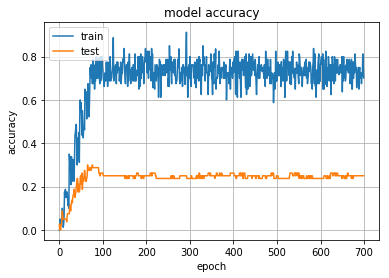

In [14]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["categorical_accuracy"])
plt.plot(history.history["val_categorical_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

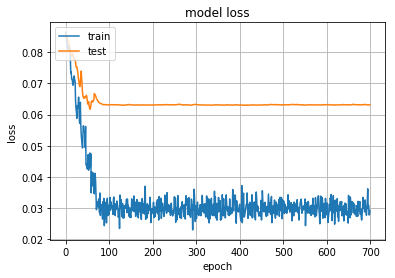

In [15]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [16]:
# Lets predict
path = valDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]

for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

file airport_26_1_msrgb.jpg is: airport
file airport_6_0_msrgb.jpg is: nuclear_powerplant
file airport_45_3_msrgb.jpg is: nuclear_powerplant
file airport_55_0_msrgb.jpg is: airport


In [17]:
loadedModel = load_model("InceptionModel.h5")

path = trainDB + os.sep + "airport" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 299, 299))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = loadedModel.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
file airport_312_0_msrgb.jpg is: airport
file airport_431_0_msrgb.jpg is: airport
file airport_139_1_msrgb.jpg is: airport
file airport_118_5_msrgb.jpg is: airport
file airport_118_2_msrgb.jpg is: airport
file airport_211_1_msrgb.jpg is: airport
file airport_7_8_msrgb.jpg is: airport
file airport_319_0_msrgb.jpg is: airport
file airport_30_6_msrgb.jpg is: airport
file airport_299_2_msrgb.jpg is: airport
file airport_118_7_msrgb.jpg is: airport
file airport_407_0_msrgb.jpg is: airport
file airport_199_7_msrgb.jpg is: airport
file airport_166_8_msrgb.jpg is: airport
file airport_40_5_msrgb.jpg is: airport
